# Lab 5: Species Distribution Modeling with Bagging 
Climate change and deforestation are accelerating ecosystem degradation, pushing animal species toward the brink of extinction. Understanding the distribution of animals and the factors that influence their ability to thrive in different environments is critical for conservation efforts. By studying these relationships, biological conservationists can develop informed strategies to protect endangered species and maintain biodiversity across diverse ecosystems.

Species are defined by their behavioral, physiological, and ecological attributes, which shape their roles in ecosystems. In turn, ecosystems and their functions are deeply influenced by the species that inhabit them. This reciprocal relationship makes evaluating species' functional diversity and distributions essential for research in biogeography, community ecology, macroevolution, and conservation. Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In this lab, we will explore the connections between animal behaviors, functional traits, and species distributions across different climates.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

### Step 1: Standardizing column names

The dataset contains several columns that describe different aspects of bird diets. These column names currently include spaces, colons (:), and special characters, which can make them difficult to work with in code.

Load the dataset (BirdTraitData.csv) into a Pandas DataFrame.

The 7 column names that start with "Diet:" should be renamed to simpler version starting with `Diet_` in a way that conforms with this list of key variables:

`AdultBodyMass`, `DietBreadth`, `Diet_Invertebrates`, `Diet_Vertebrates`,`Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`, `TrophicLevel`,`ActivityCycle`, `ForagingStratum`, `MigratoryStatus`,`IncubationTime`, `ClutchSize`, `EggLength`, `EggWidth`,`EggMass`, `NestingHabit`,`MaxLongevity`, `Subarid`

Then select only that list of 21 key variables. **Print the head of your dataframe.** 

In [2]:
# Read data
bird_data = pd.read_csv("BirdTraitData.csv", encoding = "unicode_escape")

# Look at the column names
bird_data.columns

Index(['Order', 'Family', 'Genus', 'Species', 'Authority', 'CommonName',
       'AdultBodyMass', 'DietBreadth', 'Diet: invertebrates',
       'Diet: vertebrates', 'Diet: fruits', 'Diet: flower/nectar/pollen/gums',
       'Diet: seeds', 'Diet: other plant materials',
       'Diet: scavenge; garbage; carrion; offal; carcasses', 'TrophicLevel',
       'ActivityCycle', 'ForagingStratum', 'MigratoryStatus', 'IncubationTime',
       'ClutchSize', 'EggLength', 'EggWidth', 'EggMass', 'NestingHabit',
       'MaxLongevity', 'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid',
       'Alaotra.Mangoro', 'Amoron.i.Mania', 'Analamanga', 'Analanjirofo',
       'Androy', 'Anosy', 'Atsimo.Andrefana', 'Atsimo.Atsinanana',
       'Atsinanana', 'Betsiboka', 'Boeny', 'Bongolava', 'DIANA',
       'Haute.Matsiatra', 'Ihorombe', 'Itasy', 'Melaky', 'Menabe', 'SAVA',
       'Sofia', 'Vakinankaratra', 'Vatovavy.Fitovinany', 'Antananarivo',
       'Antsiranana', 'Fianarantsoa', 'Mahajanga', 'Toamasina', 'Toliara',
 

In [3]:
# Convert to lower snake case
bird_data.columns = bird_data.columns.str.replace("Diet: ", "Diet_").str.lower()

# Simplify column names
bird_data = bird_data.rename(columns = {"diet_flower/nectar/pollen/gums": "diet_flowers", 
                                        "diet_other plant materials": "diet_plants",
                                        "diet_scavenge; garbage; carrion; offal; carcasses": "diet_other"})

# Verify
bird_data.columns

Index(['order', 'family', 'genus', 'species', 'authority', 'commonname',
       'adultbodymass', 'dietbreadth', 'diet_invertebrates',
       'diet_vertebrates', 'diet_fruits', 'diet_flowers', 'diet_seeds',
       'diet_plants', 'diet_other', 'trophiclevel', 'activitycycle',
       'foragingstratum', 'migratorystatus', 'incubationtime', 'clutchsize',
       'egglength', 'eggwidth', 'eggmass', 'nestinghabit', 'maxlongevity',
       'dry', 'humid', 'montane', 'subarid', 'subhumid', 'alaotra.mangoro',
       'amoron.i.mania', 'analamanga', 'analanjirofo', 'androy', 'anosy',
       'atsimo.andrefana', 'atsimo.atsinanana', 'atsinanana', 'betsiboka',
       'boeny', 'bongolava', 'diana', 'haute.matsiatra', 'ihorombe', 'itasy',
       'melaky', 'menabe', 'sava', 'sofia', 'vakinankaratra',
       'vatovavy.fitovinany', 'antananarivo', 'antsiranana', 'fianarantsoa',
       'mahajanga', 'toamasina', 'toliara', 'references'],
      dtype='object')

In [4]:
# Select 21 key variables (columns)
bird_data = bird_data.loc[:, "adultbodymass": "subarid"].drop(columns = ["dry", "humid", "montane"])

# Look at the first 5 rows
bird_data.head()

,adultbodymass,dietbreadth,diet_invertebrates,diet_vertebrates,diet_fruits,diet_flowers,diet_seeds,diet_plants,diet_other,trophiclevel,...,foragingstratum,migratorystatus,incubationtime,clutchsize,egglength,eggwidth,eggmass,nestinghabit,maxlongevity,subarid
0,138.5,2,yes,yes,no,no,no,no,no,3,...,3,no,31.0,3.0,3.85,-999.00,-999.0,arboreal,-999.0,1
1,1050.0,1,no,yes,no,no,no,no,no,3,...,3,no,39.5,2.5,58.50,46.95,-999.0,arboreal,-999.0,1
2,181.0,2,yes,yes,no,no,no,no,no,3,...,3,no,35.0,2.5,38.35,31.90,-999.0,arboreal,-999.0,1
3,292.0,2,yes,yes,no,no,no,no,no,3,...,3,no,31.0,1.5,43.70,35.20,29.1,arboreal,-999.0,1
4,511.0,2,yes,yes,no,no,no,no,no,3,...,4,no,35.5,2.0,54.50,45.00,-999.0,arboreal,144.0,1


### Step 2: Encode categorical variables
In our dataset, some columns contain categorical (non-numeric) data, such as species names or habitat types that need to be converted to numerical representations. Let's use label encoding to assign a unique number to each category in a column.

Encode the data using this process:
1. Find all categorical columns in df using `.select_dtypes(include=['object'])`
2. Loop through each categorical column and apply `LabelEncoder()`
3. Replace the original categorical columns with their encoded values.
4. Print the head of your dataframe to ensure that labels were in fact encoded. 

In [5]:
# Identify categorical columns
bird_data.select_dtypes(include = ["object"]).head()

,diet_invertebrates,diet_vertebrates,diet_fruits,diet_flowers,diet_seeds,diet_plants,diet_other,migratorystatus,nestinghabit
0,yes,yes,no,no,no,no,no,no,arboreal
1,no,yes,no,no,no,no,no,no,arboreal
2,yes,yes,no,no,no,no,no,no,arboreal
3,yes,yes,no,no,no,no,no,no,arboreal
4,yes,yes,no,no,no,no,no,no,arboreal


In [6]:
# Apply LabelEncoder to each categorical column
for col in bird_data.select_dtypes(include = ["object"]):
    
    label_encoders = {}
    le = LabelEncoder()
    bird_data[col] = le.fit_transform(bird_data[col])
    label_encoders[col] = le

# Verify
bird_data.dtypes

adultbodymass         float64
dietbreadth             int64
diet_invertebrates      int64
diet_vertebrates        int64
diet_fruits             int64
diet_flowers            int64
diet_seeds              int64
diet_plants             int64
diet_other              int64
trophiclevel            int64
activitycycle           int64
foragingstratum         int64
migratorystatus         int64
incubationtime        float64
clutchsize            float64
egglength             float64
eggwidth              float64
eggmass               float64
nestinghabit            int64
maxlongevity          float64
subarid                 int64
dtype: object

In [7]:
# Check for NAs (-999.0)
bird_data[bird_data == -999.0].count()

adultbodymass           2
dietbreadth             3
diet_invertebrates      0
diet_vertebrates        0
diet_fruits             0
diet_flowers            0
diet_seeds              0
diet_plants             0
diet_other              0
trophiclevel            3
activitycycle          14
foragingstratum         6
migratorystatus         0
incubationtime        100
clutchsize             28
egglength             134
eggwidth              136
eggmass               115
nestinghabit            0
maxlongevity          172
subarid                 0
dtype: int64

In [8]:
# Replace -999.0 with NaN
bird_data.replace(-999.0, np.nan, inplace = True)

# Verify the replacement
bird_data.isna().sum()

adultbodymass           2
dietbreadth             3
diet_invertebrates      0
diet_vertebrates        0
diet_fruits             0
diet_flowers            0
diet_seeds              0
diet_plants             0
diet_other              0
trophiclevel            3
activitycycle          14
foragingstratum         6
migratorystatus         0
incubationtime        100
clutchsize             28
egglength             134
eggwidth              136
eggmass               115
nestinghabit            0
maxlongevity          172
subarid                 0
dtype: int64

In [9]:
# Impute using mode
bird_data = bird_data.fillna(bird_data.mode().iloc[0])

# Check to make sure there are no NAs
bird_data[bird_data == -999.0].count()

adultbodymass         0
dietbreadth           0
diet_invertebrates    0
diet_vertebrates      0
diet_fruits           0
diet_flowers          0
diet_seeds            0
diet_plants           0
diet_other            0
trophiclevel          0
activitycycle         0
foragingstratum       0
migratorystatus       0
incubationtime        0
clutchsize            0
egglength             0
eggwidth              0
eggmass               0
nestinghabit          0
maxlongevity          0
subarid               0
dtype: int64

In [10]:
# Look at the first 5 rows
bird_data.head()

,adultbodymass,dietbreadth,diet_invertebrates,diet_vertebrates,diet_fruits,diet_flowers,diet_seeds,diet_plants,diet_other,trophiclevel,...,foragingstratum,migratorystatus,incubationtime,clutchsize,egglength,eggwidth,eggmass,nestinghabit,maxlongevity,subarid
0,138.5,2.0,2,2,1,1,1,1,1,3.0,...,3.0,0,31.0,3.0,3.85,40.00,13.5,2,134.4,1
1,1050.0,1.0,1,2,1,1,1,1,1,3.0,...,3.0,0,39.5,2.5,58.50,46.95,13.5,2,134.4,1
2,181.0,2.0,2,2,1,1,1,1,1,3.0,...,3.0,0,35.0,2.5,38.35,31.90,13.5,2,134.4,1
3,292.0,2.0,2,2,1,1,1,1,1,3.0,...,3.0,0,31.0,1.5,43.70,35.20,29.1,2,134.4,1
4,511.0,2.0,2,2,1,1,1,1,1,3.0,...,4.0,0,35.5,2.0,54.50,45.00,13.5,2,144.0,1


### Step 3: Defining features, splitting data, and training a bagging classifier
Our goal for this analysis is to predict whether a given bird species is present in Subarid climate zones. 

1. Drop the corresponding variable from the features (X) and define it as the target (y). Then perform the train-test split with 70/30 train/test and a random state of 808.

2. Initialize a bagging classifier with 100 trees, `oob_score =True`, `bootstrap = True` and `random_state = 808`.  

3. Train the model.

In [11]:
# Define features and target
X = bird_data.drop(columns = "subarid")
y = bird_data[["subarid"]]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 808)

In [12]:
# Initialize Bagging Classifier
bagging = BaggingClassifier(n_estimators = 100,
                            oob_score = True,
                            bootstrap = True,
                            random_state = 808)

In [13]:
# Train the model
bagging.fit(X_train, y_train)

/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(n_estimators=100, oob_score=True, random_state=808)

### Step 4: Make predictions and evaluate the model

1. Generate predictions
- Use the trained bagging model to predict values for the test set (`X_test`).

2. Calculate the Out-of-Bag (OOB) Score
- The OOB score is an internal validation score computed using samples not included in bootstrapped subsets.

3. Compute model accuracy
- Print the OOB score and the bagging accuracy score.

In [14]:
# Generate predictions
bagging_preds = bagging.predict(X_test)

# Calculate OOB score
oob_score = bagging.oob_score_

# Compute model accuracy
accuracy = accuracy_score(y_test, bagging_preds)

# Print OOB score and bagging accuracy score
print(f"OOB Score: {oob_score:.4f}")
print(f"Bagging Accuracy: {accuracy:.4f}")

OOB Score: 0.8698
Bagging Accuracy: 0.9452


### Step 5: Calculate and plot ROC curve

- Use `label=f"Bagging (AUC = {roc_auc_bagging:.2f})"` to include the AUC value in the plot.

In [15]:
# Calculate AUC
roc_auc_bagging = roc_auc_score(y_test, bagging.predict_proba(X_test)[:, 1])

# Print AUC
print(f"Bagging AUC: {roc_auc_bagging:.4f}")

Bagging AUC: 0.7562


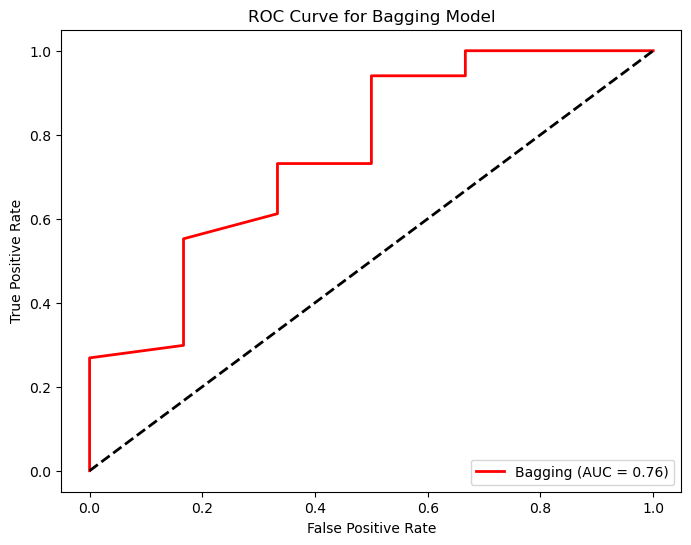

In [16]:
# Get ROC curve data
fpr, tpr, _ = roc_curve(y_test, bagging.predict_proba(X_test)[:, 1])

# Plot ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = "red", lw = 2, label = f"Bagging (AUC = {roc_auc_bagging:.2f})")

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color = "black", lw = 2, linestyle = "dashed")
    
# Add a title
plt.title("ROC Curve for Bagging Model")

# Add axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Add a legend
plt.legend(loc = "lower right")
    
# Show the plot
plt.show()

Now how does the ROC curve look? How does this compare to our classification accuracy metric?  What might be going on? 

The ROC curve appears as a zig-zag rather than a smooth curve, likely due to class imbalance. This suggests that the model may become overconfident in predicting the majority class, causing fluctuations in the curve.

### Step 6: Introducing upsampling

The ROC curve indicates that our model is not performing well.  This is a common issue in imbalanced datasets, where one class significantly outnumbers the other. To improve our model’s ability to correctly classify both groups, we will upsample the minority class so that both classes have equal representation in the training set.

**Perform upsampling to balance the dataset**
1. Separate the majority and minority classes:
- Identify which class (0,1) is underrepresented (the minority class) and which is overrepresented (the majority class). 
- Separate both the `X_train` data and `y_train` data into all majority class and all minority class sets. 
2. Apply upsampling:
- Use `resample()` to create additional synthetic samples of the minority class *with replacement* until it is the same size as the majority class data. Use a random state of 808. 
3. Combine the balanced classes:
Merge the original majority class with the newly upsampled minority class.
4. Shuffle the resampled dataset:
- Randomly shuffle the data to ensure the model does not learn any unintended patterns from the order of the data. Use a random state of 808 for shuffling both the resampled X and y training data. 
5. Print the value counts for the resampled y training data to ensure that the data is balanced. 


In [17]:
# Print initial class distribution
print(y_train["subarid"].value_counts())

subarid
1    150
0     19
Name: count, dtype: int64


In [18]:
# Separate majority and minority classes
X_train_minority = X_train.loc[y_train[y_train["subarid"] == 0].index]
X_train_majority = X_train.loc[y_train[y_train["subarid"] == 1].index]

y_train_minority = y_train[y_train["subarid"] == 0]
y_train_majority = y_train[y_train["subarid"] == 1]

# Upsample the minority class
X_train_minority_upsampled, y_train_minority_upsampled = resample(X_train_minority,
                                                                  y_train_minority,
                                                                  replace = True,
                                                                  n_samples = len(y_train_majority),
                                                                  random_state = 808)


# Combine majority and upsampled minority class
X_train_resampled = pd.concat([X_train_majority, X_train_minority_upsampled])
y_train_resampled = pd.concat([y_train_majority, y_train_minority_upsampled])

# Shuffle the dataset
X_train_resampled, y_train_resampled = resample(X_train_resampled,
                                                y_train_resampled,
                                                random_state = 808)

# Print value counts 
print(y_train_resampled["subarid"].value_counts())

subarid
0    159
1    141
Name: count, dtype: int64


### Step 7: Retrain and evaluate model using balanced data

Now that we have addressed the class imbalance by upsampling the minority class, we will retrain the bagging classifier on the newly balanced dataset and evaluate its performance. This will help us determine whether handling class imbalance improves model accuracy and its ability to distinguish between classes. Create a bagging model using your balanced data. Use a random state of 808. Print the accuracy and and ROC Curve for this new model with balanced data. 

In [19]:
# Re-train the model on balanced dataset
bagging.fit(X_train_resampled, y_train_resampled.values.ravel())

# Generate predictions
balanced_preds = bagging.predict(X_test)

# Compute model accuracy
accuracy_balanced = accuracy_score(y_test, balanced_preds)

# Calculate ROC AUC for the balanced model
roc_auc_balanced = roc_auc_score(y_test, bagging.predict_proba(X_test)[:, 1])

# Print new accuracy and ROC AUC
print(f"Bagging Accuracy after Upsampling: {accuracy_balanced:.4f}")
print(f"Bagging AUC after Upsampling: {roc_auc_balanced:.4f}")

Bagging Accuracy after Upsampling: 0.8904
Bagging AUC after Upsampling: 0.7687


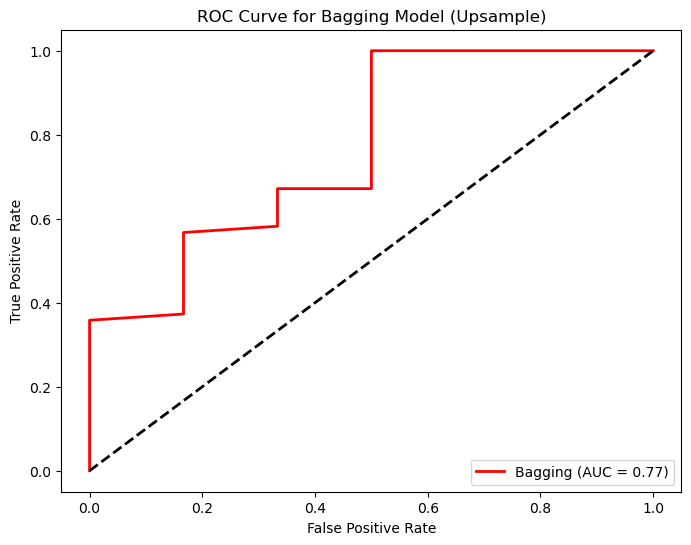

In [20]:
# Get ROC curve data
fpr, tpr, _ = roc_curve(y_test, bagging.predict_proba(X_test)[:, 1])

# Plot ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = "red", lw = 2, label = f"Bagging (AUC = {roc_auc_balanced:.2f})")

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color = "black", lw = 2, linestyle = "dashed")
    
# Add a title
plt.title("ROC Curve for Bagging Model (Upsample)")

# Add axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Add a legend
plt.legend(loc = "lower right")
    
# Show the plot
plt.show()

How did this second model, trained on balanced data, do in comparison to the first on the accuracy and AUC metrics.  How should we interpret those results?  Did the upscaling prove useful?

After training the model on the balanced data, we observed a decrease in accuracy, likely due to the model's behavior after upsampling the minority class. However, there was a slight improvement in AUC, indicating that the model's ability to distinguish between the classes improved slightly. While upsampling led to a lower accuracy, it can still be useful in improving the model's predictive performance.

### Step 8: Analyzing feature importance with permutation importance

Understanding which bird traits contribute the most to our model’s predictions is crucial for interpreting results. We covered in lecture how the results of ensemble methods are harder to interpret than a single decision tree.  But we do have some tools to do it.  In this step, we will compute permutation importance, which measures the impact of each trait by shuffling its values and observing the effect on model performance. This will help us identify which functional traits—such as diet, body mass, or habitat breadth—play the biggest role in predicting whether a species is found in a subarid environment.

Use `permutation_importance()` to calculate the importance values.  You'll need to pass it the model, the feature and target test data, and an n_repeats value of 10.

In [21]:
# Compute permutation importance
result = permutation_importance(bagging, X_test, y_test, n_repeats = 10, random_state = 808)

# Get the mean and standard deviation of importance values
importance_mean = result.importances_mean
importance_std = result.importances_std

# Sort features by importance
sorted_idx = np.argsort(importance_mean)
sorted_idx

array([17, 14, 13,  1, 19,  6,  9,  8,  2, 15,  7,  3, 16,  5, 11, 12,  4,
       10,  0, 18])

In [22]:
X_test.columns[sorted_idx]

Index(['eggmass', 'clutchsize', 'incubationtime', 'dietbreadth',
       'maxlongevity', 'diet_seeds', 'trophiclevel', 'diet_other',
       'diet_invertebrates', 'egglength', 'diet_plants', 'diet_vertebrates',
       'eggwidth', 'diet_flowers', 'foragingstratum', 'migratorystatus',
       'diet_fruits', 'activitycycle', 'adultbodymass', 'nestinghabit'],
      dtype='object')

What features are most important in our model of species distribution?

Based on permutation importance, egg mass is identified as the most significant factor in predicting whether a species can be found in a subarid environment. This indicates that the size of the eggs plays a crucial role in the species' ability to thrive in such climates. Following egg mass, clutch size and incubation time are also important predictors.